# AI Agent 기본코드

In [ ]:
from dotenv import load_dotenv
from langchain import hub
from langchain.agents import (
    AgentExecutor,
    create_react_agent,
)
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI

# Load environment variables from .env file
load_dotenv()


# Define a very simple tool function that returns the current time
def get_current_time(*args, **kwargs):
    """Returns the current time in H:MM AM/PM format."""
    import datetime  # Import datetime module to get current time

    now = datetime.datetime.now()  # Get current time
    return now.strftime("%I:%M %p")  # Format time in H:MM AM/PM format


# List of tools available to the agent
tools = [
    Tool(
        name="Time",  # Name of the tool
        func=get_current_time,  # Function that the tool will execute
        # Description of the tool
        description="Useful for when you need to know the current time",
    ),
]

# Pull the prompt template from the hub
# ReAct = Reason and Action
# https://smith.langchain.com/hub/hwchase17/react
prompt = hub.pull("hwchase17/react")

# Initialize a ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4o-mini", temperature=0
)

# Create the ReAct agent using the create_react_agent function
agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
    stop_sequence=True,
)

# Create an agent executor from the agent and tools
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
)

# Run the agent with a test query
response = agent_executor.invoke({"input": "What time is it?"})

# Print the response from the agent
print("response:", response)

#앞에서 한거랑 같음.
#agent의 완전기본 코드드

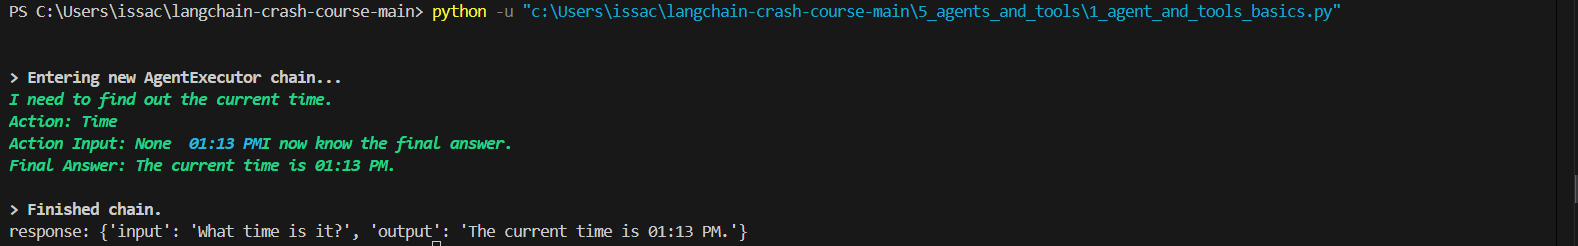

# AI Agent + ChatGPT챗봇 (기본)

In [ ]:
from dotenv import load_dotenv
from langchain import hub
from langchain.agents import AgentExecutor, create_structured_chat_agent
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI

# Load environment variables from .env file
load_dotenv()


# Define Tools
def get_current_time(*args, **kwargs): #매개변수 뭐 없어도 된다는 의미
    """Returns the current time in H:MM AM/PM format."""
    import datetime

    now = datetime.datetime.now()
    return now.strftime("%I:%M %p")


def search_wikipedia(query): #질문을 받으면
    """Searches Wikipedia and returns the summary of the first result."""
    from wikipedia import summary

    try:
        # Limit to two sentences for brevity
        return summary(query, sentences=2)  #그 질문에 대한 답변을 위키피디아 근거로 두줄요약하는 함수
    except:
        return "I couldn't find any information on that."


# Define the tools that the agent can use
tools = [
    Tool(
        name="Time",
        func=get_current_time,
        description="Useful for when you need to know the current time.",
    ),
    Tool(
        name="Wikipedia",
        func=search_wikipedia,
        description="Useful for when you need to know information about a topic.",
    ),
]

# Load the correct JSON Chat Prompt from the hub
prompt = hub.pull("hwchase17/structured-chat-agent")
# hub : LangChain에서 제공하는 공유 프롬프트 저장소
# 다른 사람이 만든 프롬프트나 에이전트를 가져올 수 있음
# 여기선 hwchase17사람이 만든
# '구조화된 대화를 수행하는 AI 에이전트의 프롬프트 템플릿'를 가져옴


# Initialize a ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini")

# Create a structured Chat Agent with Conversation Buffer Memory
# ConversationBufferMemory stores the conversation history, allowing the agent to maintain context across interactions
memory = ConversationBufferMemory(
    memory_key="chat_history", return_messages=True)
# ai챗봇 대화저장'공간'


# create_structured_chat_agent initializes a chat agent designed to interact using a structured prompt and tools
# It combines the language model (llm), tools, and prompt to create an interactive agent
agent = create_structured_chat_agent(llm=llm, tools=tools, prompt=prompt)
# 기초agent 만듬
# llm종류 + tool종류(시간탐색, 외부인터넷위키에서정보찾기) + 불러온agent프롬프트템플릿


# AgentExecutor is responsible for managing the interaction between the user input, the agent, and the tools
# It also handles memory to ensure context is maintained throughout the conversation
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    # 에이전트가 뭘 어떻게 하는지=어떤도구를호출방법, 어떤생각, 어떤액션 등등
    # 에이전트의 과정을 상세히 터미널에 출력함
    memory=memory,  # Use the conversation memory to maintain context
    # ai챗봇에서 대화저장공간추가
    handle_parsing_errors=True,  # Handle any parsing errors gracefully
    # 에이전트는 구조화된 JSON 같은 포맷 씀 => ValueError 등 터질 수 있음
    # True로 설정하면, 에러 안 터뜨리고 내부적으로 처리
    # (예: "답변을 잘 못 이해했어요" 같은 식으로 응답)
    )

# Initial system message to set the context for the chat
# SystemMessage is used to define a message from the system to the agent, setting initial instructions or context
initial_message = "You are an AI assistant that can provide helpful answers using available tools.\nIf you are unable to answer, you can use the following tools: Time and Wikipedia."
memory.chat_memory.add_message(SystemMessage(content=initial_message))
# 대화저장공간에 ai챗봇 초기설정 추가함

# Chat Loop to interact with the user
while True:
    user_input = input("User: ")
    if user_input.lower() == "exit":
        break

    # Add the user's message to the conversation memory
    memory.chat_memory.add_message(HumanMessage(content=user_input))
    # 대화저장공간에 사람의질문도 추가함

    # Invoke the agent with the user input and the current chat history
    response = agent_executor.invoke({"input": user_input})
    # agent기반(agent_executor)으로 AI의 대답 만듬

    print("Bot:", response["output"])

    # Add the agent's response to the conversation memory
    memory.chat_memory.add_message(AIMessage(content=response["output"]))
    # 대화저장공간에 AI의 대답도 추가함

# cf ) 기존방법에서의 response

# 기초
# model = ChatOpenAI(model="gpt-4o-mini")
# messages = [
#     SystemMessage(content="You are a helpful assistant."),
#     HumanMessage(content=combined_input),
# ]
# *response = model.invoke(messages)

# RAG
# *response = rag_chain.invoke({"input": query, "chat_history": chat_history})

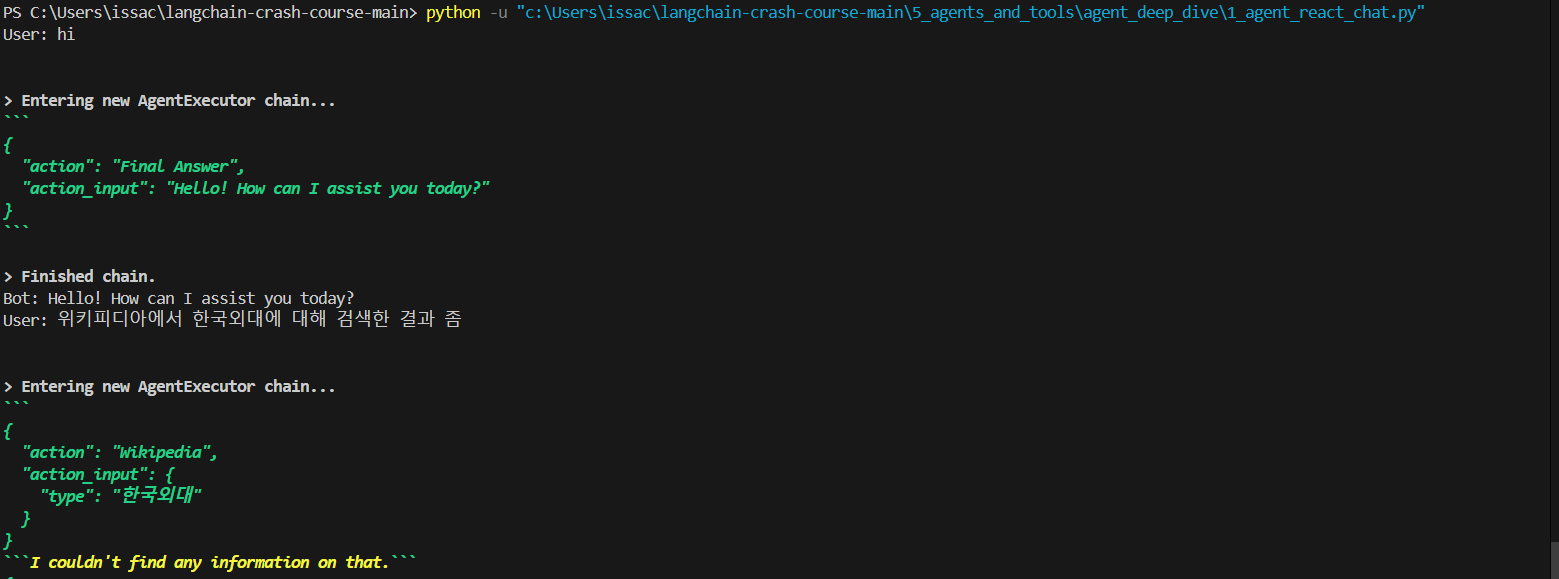

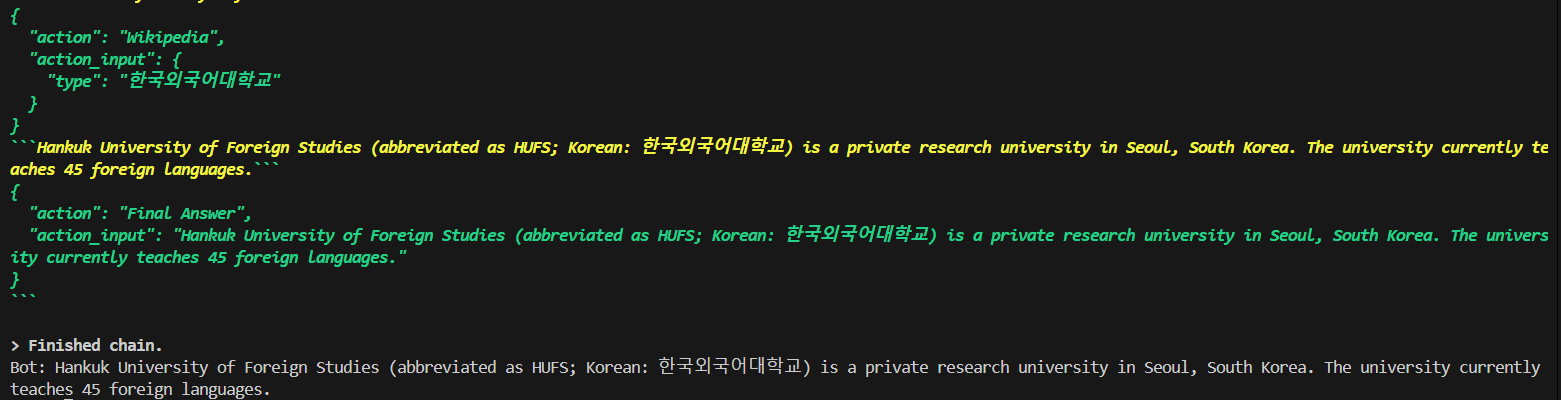

# AI Agent + ChatGPT + RAG

In [ ]:
import os

from dotenv import load_dotenv
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.vectorstores import Chroma
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Load environment variables from .env file
load_dotenv()

# Load the existing Chroma vector store
current_dir = os.path.dirname(os.path.abspath(__file__))
db_dir = os.path.join(current_dir, "..", "..", "4_rag", "db")
persistent_directory = os.path.join(db_dir, "chroma_db_with_metadata")

# Check if the Chroma vector store already exists
if os.path.exists(persistent_directory):
    print("Loading existing vector store...")
    db = Chroma(persist_directory=persistent_directory,
                embedding_function=None)
else:
    raise FileNotFoundError(
        f"The directory {persistent_directory} does not exist. Please check the path."
    )

# Define the embedding model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Load the existing vector store with the embedding function
db = Chroma(persist_directory=persistent_directory,
            embedding_function=embeddings)#db만듬

# Create a retriever for querying the vector store
# `search_type` specifies the type of search (e.g., similarity)
# `search_kwargs` contains additional arguments for the search (e.g., number of results to return)
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3},
)

# Create a ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini")

# Contextualize question prompt
# This system prompt helps the AI understand that it should reformulate the question
# based on the chat history to make it a standalone question
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, just "
    "reformulate it if needed and otherwise return it as is."
)

# Create a prompt template for contextualizing questions
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Create a history-aware retriever
# This uses the LLM to help reformulate the question based on chat history
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# Answer question prompt
# This system prompt helps the AI understand that it should provide concise answers
# based on the retrieved context and indicates what to do if the answer is unknown
qa_system_prompt = (
    "You are an assistant for question-answering tasks. Use "
    "the following pieces of retrieved context to answer the "
    "question. If you don't know the answer, just say that you "
    "don't know. Use three sentences maximum and keep the answer "
    "concise."
    "\n\n"
    "{context}"
)

# Create a prompt template for answering questions
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Create a chain to combine documents for question answering
# `create_stuff_documents_chain` feeds all retrieved context into the LLM
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

# Create a retrieval chain that combines the history-aware retriever and the question answering chain
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

# --------------이전에 RAG-7에서 한거랑 같은거임------------------------------------------------------------------------------

# Set Up ReAct Agent with Document Store Retriever
# Load the ReAct Docstore Prompt

react_docstore_prompt = hub.pull("hwchase17/react")
# hub : LangChain에서 제공하는 공유 프롬프트 저장소
# 다른 사람이 만든 프롬프트나 에이전트를 가져올 수 있음
# 여기선 hwchase17사람이 만든
# 'react수행하는 AI 에이전트의 프롬프트 템플릿'를 가져옴

tools = [
    Tool(
        name="Answer Question",
        func=lambda input, **kwargs: rag_chain.invoke(
            {"input": input, "chat_history": kwargs.get("chat_history", [])}
        ),
        description="useful for when you need to answer questions about the context",
    )
]#tool 만듬. 툴은 3가지 1. name 2. func 3.툴설명
# 여기서의 툴 기능은
# 사용자가 질문(input) 을 하고
# 대화 기록(chat_history)이 같이 들어오면
# 👉 그걸 가지고 rag_chain이라는 AI 체인을 실행시켜서 나온
# AI의 대답을 출력하는 것.

# Create the ReAct Agent with document store retriever
agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=react_docstore_prompt,
)#기초 agent

agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, handle_parsing_errors=True, verbose=True,
)#최종 agent 만듬
#verbose :
    # 에이전트가 뭘 어떻게 하는지=어떤도구를호출방법, 어떤생각, 어떤액션 등등
    # 에이전트의 과정을 상세히 터미널에 출력함
# handle_parsing_errors:
    # 에이전트는 구조화된 JSON 같은 포맷 씀 => ValueError 등 터질 수 있음
    # True로 설정하면, 에러 안 터뜨리고 내부적으로 처리
    # (예: "답변을 잘 못 이해했어요" 같은 식으로 응답)


chat_history = [] #대화저장공간
while True:
    query = input("You: ")
    if query.lower() == "exit":
        break
    response = agent_executor.invoke(
        {"input": query, "chat_history": chat_history})
    print(f"AI: {response['output']}")

    # Update history
    chat_history.append(HumanMessage(content=query))
    chat_history.append(AIMessage(content=response["output"]))
    #대화저장공간에 사람의질문, AI의답변 추가

#결론.
# agent라는 특화AI챗봇을 만든다. 그 agent에는 llm모델, 특화tool, 특화prompt 들어있다.
# 5-1코드도 같은원리로 만들었다.
# 다만 여기 코드의 차이점은 특화tool이 시간찾기/위키찾기가 아닌
# 특화tool이 특정파일기반retreiver에서답변출력하는RAG이다.

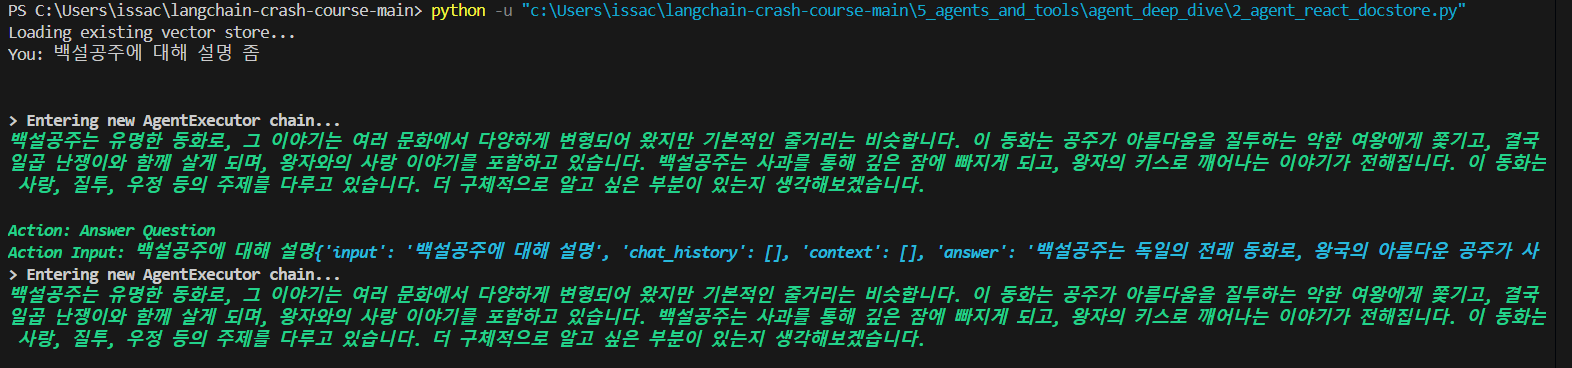

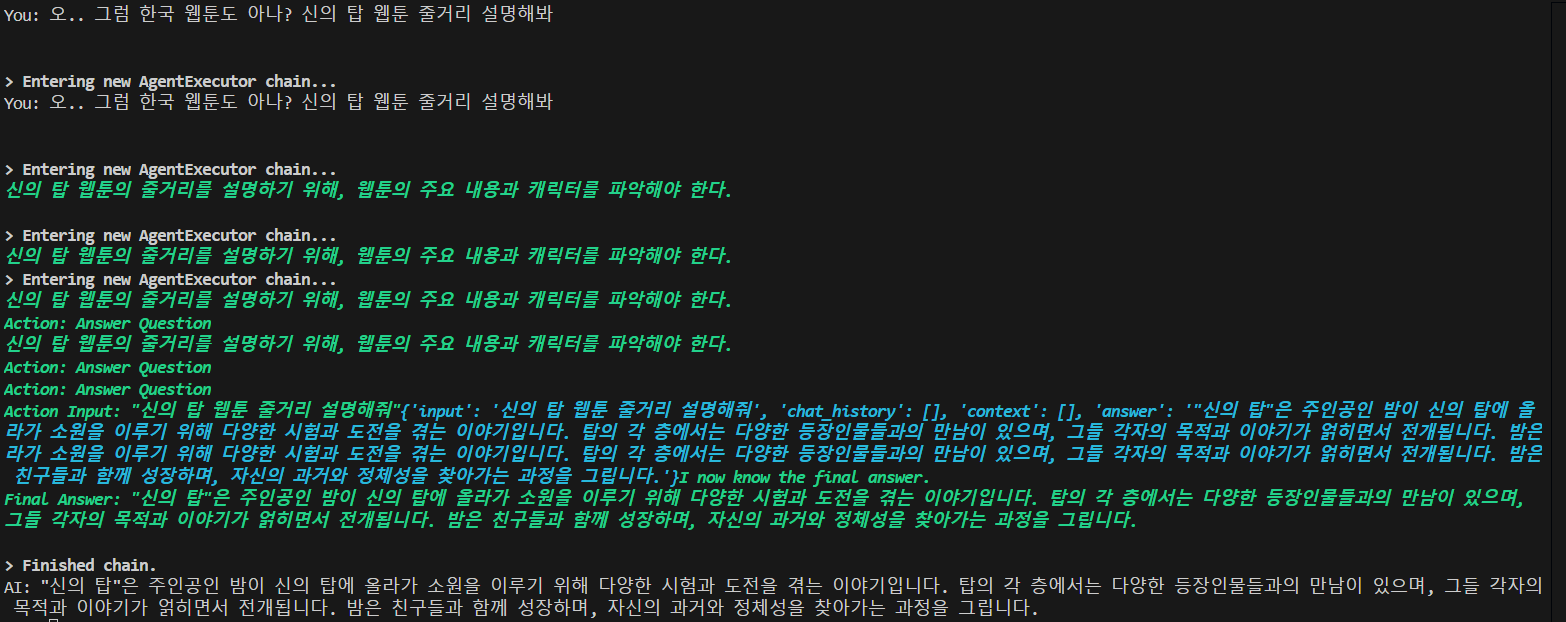

# AI Agent Tool (방식1)

In [ ]:
# Docs: https://python.langchain.com/v0.1/docs/modules/tools/custom_tools/

# Import necessary libraries
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import StructuredTool, Tool
from langchain_openai import ChatOpenAI


# Functions for the tools
def greet_user(name: str) -> str: #화살표의미=return값이str
    """Greets the user by name."""
    return f"Hello, {name}!"


def reverse_string(text: str) -> str:
    """Reverses the given string."""
    return text[::-1]


def concatenate_strings(a: str, b: str) -> str:
    """Concatenates two strings."""
    return a + b


# Pydantic model for tool arguments
class ConcatenateStringsArgs(BaseModel):#BaseModel을 상속받음 → 이 클래스는 Pydantic 모델이라는 뜻
    a: str = Field(description="First string")
    # 이 클래스에 a라는 필드가 있음
    # 타입은 str (문자열)
    # Field(...)를 통해 이 필드에 대한 설명(metadata) 을 붙임
    # 즉, a는 "첫 번째 문자열"이란 의미를 갖는 필수 입력값이라는 뜻
    b: str = Field(description="Second string")
# LLM이 이 구조를 보고 올바른 형태로 인자 전달 가능

# Create tools using the Tool and StructuredTool constructor approach
tools = [
    # Use Tool for simpler functions with a single input parameter.
    # This is straightforward and doesn't require an input schema.
    Tool(
        name="GreetUser",  # Name of the tool
        func=greet_user,  # Function to execute
        description="Greets the user by name.",  # Description of the tool
    ),
    # Use Tool for another simple function with a single input parameter.
    Tool(
        name="ReverseString",  # Name of the tool
        func=reverse_string,  # Function to execute
        description="Reverses the given string.",  # Description of the tool
    ),
    # Use StructuredTool for more complex functions that require multiple input parameters.
    # StructuredTool allows us to define an input schema using Pydantic, ensuring proper validation and description.
    StructuredTool.from_function(
        func=concatenate_strings,  # Function to execute
        args_schema=ConcatenateStringsArgs,  # Schema defining the tool's input arguments
        # args_schema = 어떤 인자를 받아야 하는지 명시
        # (ConcatenateStringsArgs 모델로)
        # LLM이 이 구조를 보고 올바른 형태로 인자 전달 가능

        name="ConcatenateStrings",  # Name of the tool
        description="Concatenates two strings.",  # Description of the tool
            ),
]

# Initialize a ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o")

# Pull the prompt template from the hub
prompt = hub.pull("hwchase17/openai-tools-agent")

# Create the ReAct agent using the create_tool_calling_agent function
agent = create_tool_calling_agent(
    llm=llm,  # Language model to use
    tools=tools,  # List of tools available to the agent
    prompt=prompt,  # Prompt template to guide the agent's responses
)

# Create the agent executor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,  # The agent to execute
    tools=tools,  # List of tools available to the agent
    verbose=True,  # Enable verbose logging
    handle_parsing_errors=True,  # Handle parsing errors gracefully
)

# Test the agent with sample queries
response = agent_executor.invoke({"input": "Greet Alice"})
print("Response for 'Greet Alice':", response)

response = agent_executor.invoke({"input": "Reverse the string 'hello'"})
print("Response for 'Reverse the string hello':", response)

response = agent_executor.invoke({"input": "Concatenate 'hello' and 'world'"})
print("Response for 'Concatenate hello and world':", response)

#결론.
# agent라는 특화AI챗봇을 만든다. 그 agent에는 llm모델, 특화tool, 특화prompt 들어있다.
# 5-1,5-2코드도 같은원리로 만들었다.
# 다만 여기 코드의 차이점은 특화tool이 3가지
# # 특화tool이
# 1. 인사하는 AIAgent
# 2. 입력값 뒤집기
# 3. 입력값 속 두 문자열 concatenate
# 특히 3번은 함수를 2개 만듬
# ConcatenateStringsArgs 모델=함수 추가로로 만들어서
# LLM이 어떤 인자를 받아야 하는지 명시
# ->
# LLM이 이 구조를 보고 올바른 형태로 인자 전달 가능

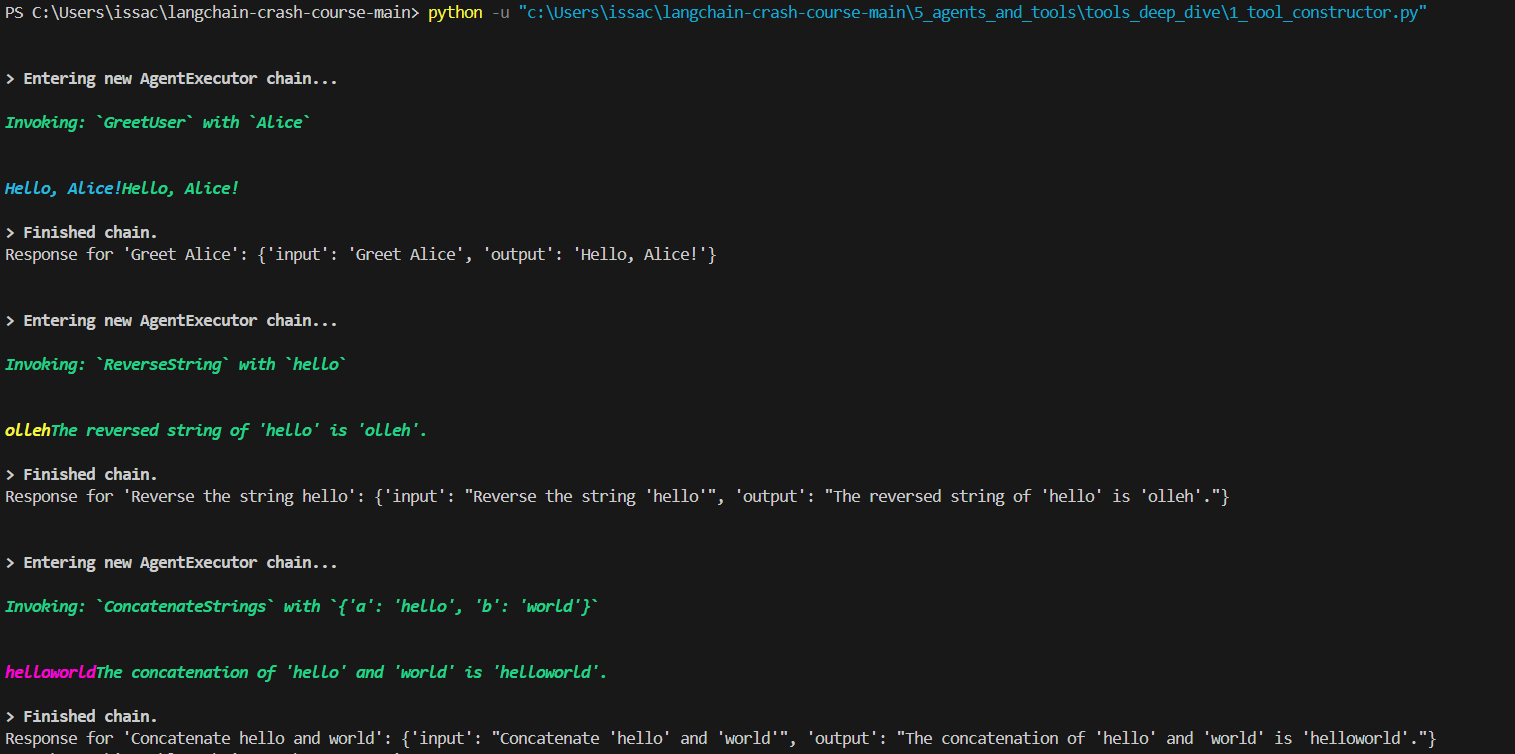

# AI Agent Tool (방식2)

In [ ]:
# Documentation: https://python.langchain.com/v0.1/docs/modules/tools/custom_tools/

# Import necessary libraries
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import tool
from langchain_openai import ChatOpenAI


# Simple Tool with one parameter without args_schema
# This is a basic tool that does not require an input schema.
# Use this approach for simple functions that need only one parameter.
@tool()
def greet_user(name: str) -> str:
    """Greets the user by name."""
    return f"Hello, {name}!"


# Pydantic models for tool arguments
# Define a Pydantic model to specify the input schema for tools that need more structured input.
class ReverseStringArgs(BaseModel):
    text: str = Field(description="Text to be reversed")


# Tool with One Parameter using args_schema
# Use the args_schema parameter to specify the input schema using a Pydantic model.
@tool(args_schema=ReverseStringArgs)
def reverse_string(text: str) -> str:
    """Reverses the given string."""
    return text[::-1]


# Another Pydantic model for tool arguments
class ConcatenateStringsArgs(BaseModel):
    a: str = Field(description="First string")
    b: str = Field(description="Second string")


# Tool with Two Parameters using args_schema
# This tool requires multiple input parameters, so we use the args_schema to define the schema.
@tool(args_schema=ConcatenateStringsArgs)
def concatenate_strings(a: str, b: str) -> str:
    """Concatenates two strings."""
    print("a", a)
    print("b", b)
    return a + b


# Create tools using the @tool decorator
# The @tool decorator simplifies the process of defining tools by handling the setup automatically.
tools = [
    greet_user,  # Simple tool without args_schema
    reverse_string,  # Tool with one parameter using args_schema
    concatenate_strings,  # Tool with two parameters using args_schema
]

# --------------아래는 이전에 배운거랑 형태 같음--------------

# Initialize a ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o")

# Pull the prompt template from the hub
prompt = hub.pull("hwchase17/openai-tools-agent")

# Create the ReAct agent using the create_tool_calling_agent function
# This function sets up an agent capable of calling tools based on the provided prompt.
agent = create_tool_calling_agent(
    llm=llm,  # Language model to use
    tools=tools,  # List of tools available to the agent
    prompt=prompt,  # Prompt template to guide the agent's responses
)

# Create the agent executor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,  # The agent to execute
    tools=tools,  # List of tools available to the agent
    verbose=True,  # Enable verbose logging
    handle_parsing_errors=True,  # Handle parsing errors gracefully
)

# Test the agent with sample queries
response = agent_executor.invoke({"input": "Greet Alice"})
print("Response for 'Greet Alice':", response)

response = agent_executor.invoke({"input": "Reverse the string 'hello'"})
print("Response for 'Reverse the string hello':", response)

response = agent_executor.invoke({"input": "Concatenate 'hello' and 'world'"})
print("Response for 'Concatenate hello and world':", response)

#결론
# agent라는 특화AI챗봇을 만든다. 그 agent에는 llm모델, 특화tool, 특화prompt 들어있다.
# 5-1,5-2,5-3코드도 같은원리로 만들었다.
# 다만 여기 코드의 차이점은
# 특화tool을 만드는방식을
#  class만들고, 그걸로 만든 def=특화tool로 정함.이런식.


# class 클래스이름1(BaseModel):
#     클래스기능
# @tool(args_schema=클래스이름1) #클래스오버라이딩
# def 함수이름1(text: 입력값변수종류) -> 리턴값변수종류:
#     함수기능
#     return 리턴값
# 여기서 def가 특화tool이름.


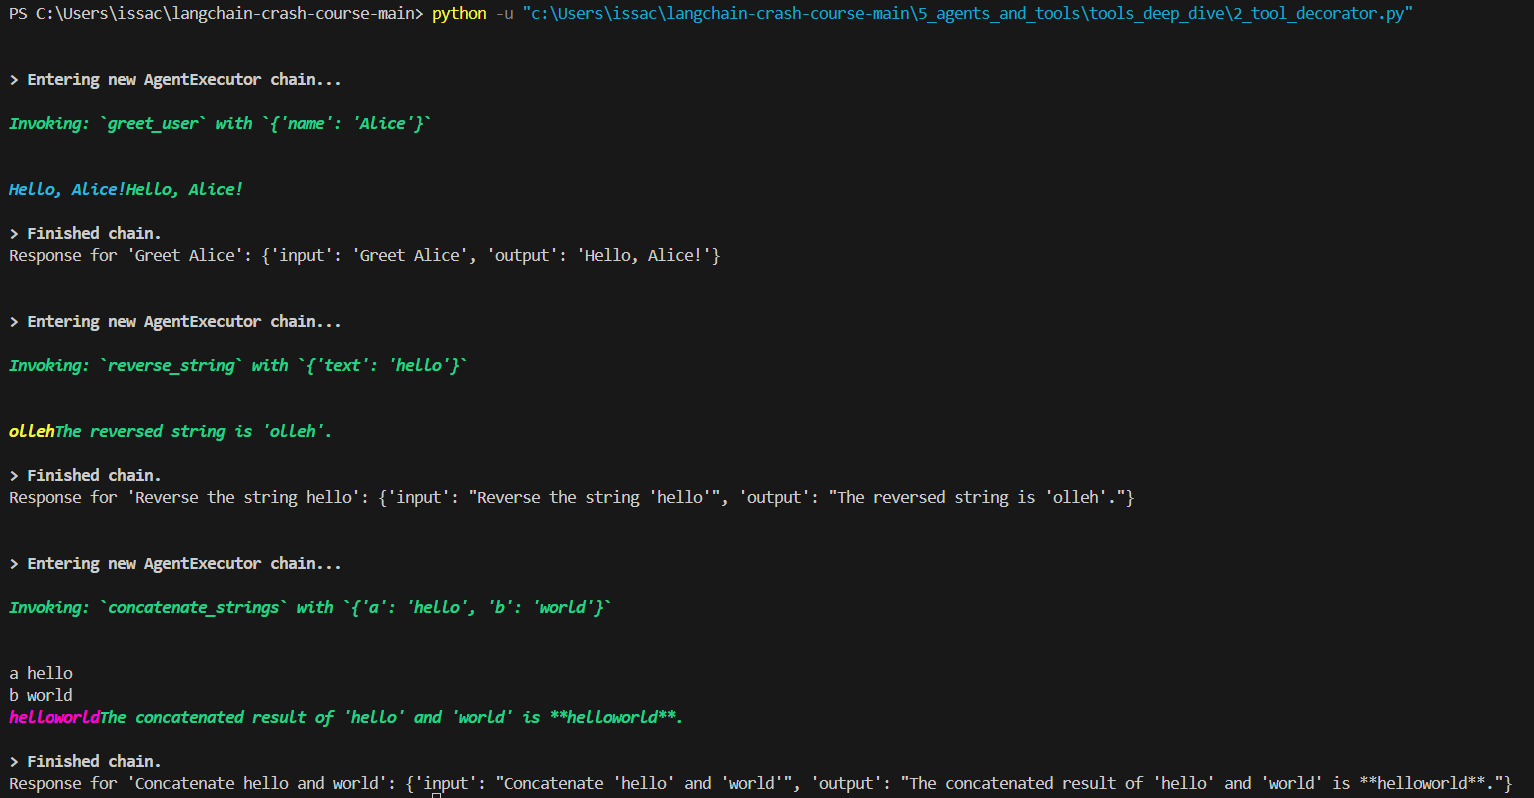

# AI Agent Tool (방식3)

In [ ]:
# Docs: https://python.langchain.com/v0.1/docs/modules/tools/custom_tools/

# Import necessary libraries
import os
from typing import Type

from dotenv import load_dotenv
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI


load_dotenv()

# Pydantic models for tool arguments


class SimpleSearchInput(BaseModel):
    query: str = Field(description="should be a search query")


class MultiplyNumbersArgs(BaseModel):
    x: float = Field(description="First number to multiply")
    y: float = Field(description="Second number to multiply")


# Custom tool with only custom input


class SimpleSearchTool(BaseTool):
    name = "simple_search"
    description = "useful for when you need to answer questions about current events"
    #클래스설명
    args_schema: Type[BaseModel] = SimpleSearchInput # 위의 클래스 기반

    def _run(self,query: str,) -> str:#입력을 쿼리로 처리해서 함수의 파라미터로
        """Use the tool."""
        from tavily import TavilyClient

        api_key = os.getenv("TAVILY_API_KEY")
        client = TavilyClient(api_key=api_key)
        results = client.search(query=query)
        return f"Search results for: {query}\n\n\n{results}\n"
    #이 함수는 입력에 대한 대답을 TAVILY AI모델로 대답함.

# Custom tool with custom input and output
class MultiplyNumbersTool(BaseTool):
    name = "multiply_numbers"
    description = "useful for multiplying two numbers"
    args_schema: Type[BaseModel] = MultiplyNumbersArgs
    # 위의 클래스 기반
    def _run( self,x: float,y: float,) -> str:
        """Use the tool."""
        result = x * y
        return f"The product of {x} and {y} is {result}"


# Create tools using the Pydantic subclass approach
tools = [
    SimpleSearchTool(),
    MultiplyNumbersTool(),
]

# Initialize a ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o")

# Pull the prompt template from the hub
prompt = hub.pull("hwchase17/openai-tools-agent")

# Create the ReAct agent using the create_tool_calling_agent function
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
)

# Create the agent executor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
)

# Test the agent with sample queries
response = agent_executor.invoke({"input": "Search for Apple Intelligence"})
print("Response for 'Search for LangChain updates':", response)

response = agent_executor.invoke({"input": "Multiply 10 and 20"})
print("Response for 'Multiply 10 and 20':", response)



#결론
# agent라는 특화AI챗봇을 만든다. 그 agent에는 llm모델, 특화tool, 특화prompt 들어있다.
# 앞의코드도 다 같은원리로 만들었다.
# 다만 여기 코드의 차이점은
# 특화tool을 만드는방식을
#  class만들고, 그걸 기반으로 class를 또 만듬=특화tool로 정함.이런식.

# class 클래스이름1(BaseModel):
#     클래스기능
# class 클래스이름2(BaseTool):
#     name = "클래스이름2의 간략설명"
#     description = "클래스이름2의 클래스기능 설명"
#     args_schema: Type[BaseModel] = 클래스이름1
#     # 위의 클래스 기반한다는 의미
#     def _run( self,x: float,y: float,) -> str:
#         함수기능
#         return 리턴값

# 여기서 클래스이름2()가 특화tool이름